In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, interp1d, InterpolatedUnivariateSpline
from scipy.optimize import fsolve, minimize,minimize_scalar,root_scalar
import time

In [57]:
# 8.7 VFI with borrowing constraint

# parameters
gamma = 0.5
beta = 0.975
r = 0.02
w = 1
a_bar = 4 #borrowing limit, assets must be => -a_bar

# grid setup
a_min = -a_bar
a_max = w / r
grid_a = np.linspace(a_min, a_max, 501)
tol = 1e-6
max_iter = 1000
T_sim = 200

# utility functions
def utility(c):
    c = np.maximum(c, 1e-12)
    return (c**(1 - gamma)) / (1 - gamma)

def marg_utility(c):
    c = np.maximum(c, 1e-12)
    return c**(-gamma)

def inv_marg_utility(mu):
    mu = np.maximum(mu, 1e-12)
    return mu ** (-1 / gamma)

def bellman(value_func_interp, a):
    income = (1 + r) * a + w
    c_min = 1e-10
    c_max = income - a_min  # ensure a' ≥ -ā
    

    def obj(c):
        if c <= 0 or c > c_max:
            return 1e10
        a_next = income - c
        if a_next < a_min:
            return 1e10  # enforce borrowing constraint
        return -(utility(c) + beta * value_func_interp(a_next))

    res = minimize_scalar(obj, bounds=(c_min, c_max), method='bounded')
    return -res.fun, res.x

V = utility((1 + r) * grid_a + w)
policy_vfi = np.zeros_like(grid_a)

for it in range(max_iter):
    V_new = np.zeros_like(V)
    V_func = interp1d(grid_a, V, kind='linear', fill_value='extrapolate')
    for i, a in enumerate(grid_a):
        V_new[i], policy_vfi[i] = bellman(V_func, a)
    if np.max(np.abs(V - V_new)) < tol:
        print(f"[VFI] Converged in {it+1} iterations.")
        break
    V = V_new.copy()

[VFI] Converged in 573 iterations.


In [58]:
# 8.8 FOC with borrowing constraint

def foc(x, a_i, spline_c):
    c_plus = spline_c(np.minimum(x, grid_a[-1]))
    rhs = (beta * (1 + r)) ** (-gamma) * c_plus
    lhs = (1 + r) * grid_a[a_i] + w - x
    return lhs - rhs

c_foc = utility((1 + r) * grid_a + w)  # initial guess

for it in range(max_iter):
    c_new = np.zeros_like(c_foc)
    spline_c = InterpolatedUnivariateSpline(grid_a, c_foc, k=3)

    for i in range(len(grid_a)):
        income = (1 + r) * grid_a[i] + w
        a_next_min = a_min
        a_next_max = income
        try:
            sol = root_scalar(foc, args=(i, spline_c),
                              bracket=(a_next_min, a_next_max), method='brentq')
            c_new[i] = income - sol.root
        except ValueError:
            c_new[i] = 1e-10

    diff = np.max(np.abs(c_new - c_foc) / np.maximum(c_foc, 1e-10))
    if diff < tol:
        print(f"[FOC] Converged in {it+1} iterations.")
        break
    c_foc = c_new.copy()


In [59]:
#8.9 EGM with borrow constraint

c_egm = (r * grid_a + w) / 2

for it in range(max_iter):
    c_next = c_egm.copy()
    mu_next = marg_utility(c_next)
    c_now = inv_marg_utility(beta * (1 + r) * mu_next)
    a_now = (c_now + grid_a - w) / (1 + r)
    a_now = np.maximum(a_now, a_min)  # enforce constraint
    c_new = np.interp(grid_a, a_now, c_now, left=0.0, right=c_now[-1])

    if np.max(np.abs(c_new - c_egm) / np.maximum(c_egm, 1e-10)) < tol:
        print(f"[EGM] Converged in {it+1} iterations.")
        c_egm = c_new
        break
    c_egm = c_new

In [60]:
# simulate paths

def simulate(policy_func, T=T_sim):
    a = np.zeros(T+1)
    c = np.zeros(T+1)
    for t in range(T):
        c[t] = np.maximum(policy_func(a[t]), 1e-12)
        a[t+1] = (1 + r) * a[t] + w - c[t]
        a[t+1] = max((1 + r) * a[t] + w - c[t], a_min)  # enforce borrowing constraint
    return a, c

policy_func_vfi = interp1d(grid_a, policy_vfi, kind='linear', fill_value='extrapolate')
policy_func_foc = interp1d(grid_a, c_foc, kind='linear', fill_value='extrapolate')
policy_func_egm = interp1d(grid_a, c_egm, kind='linear', fill_value='extrapolate')

a_vfi, c_vfi = simulate(policy_func_vfi)
a_foc, c_foc_sim = simulate(policy_func_foc)
a_egm, c_egm_sim = simulate(policy_func_egm)

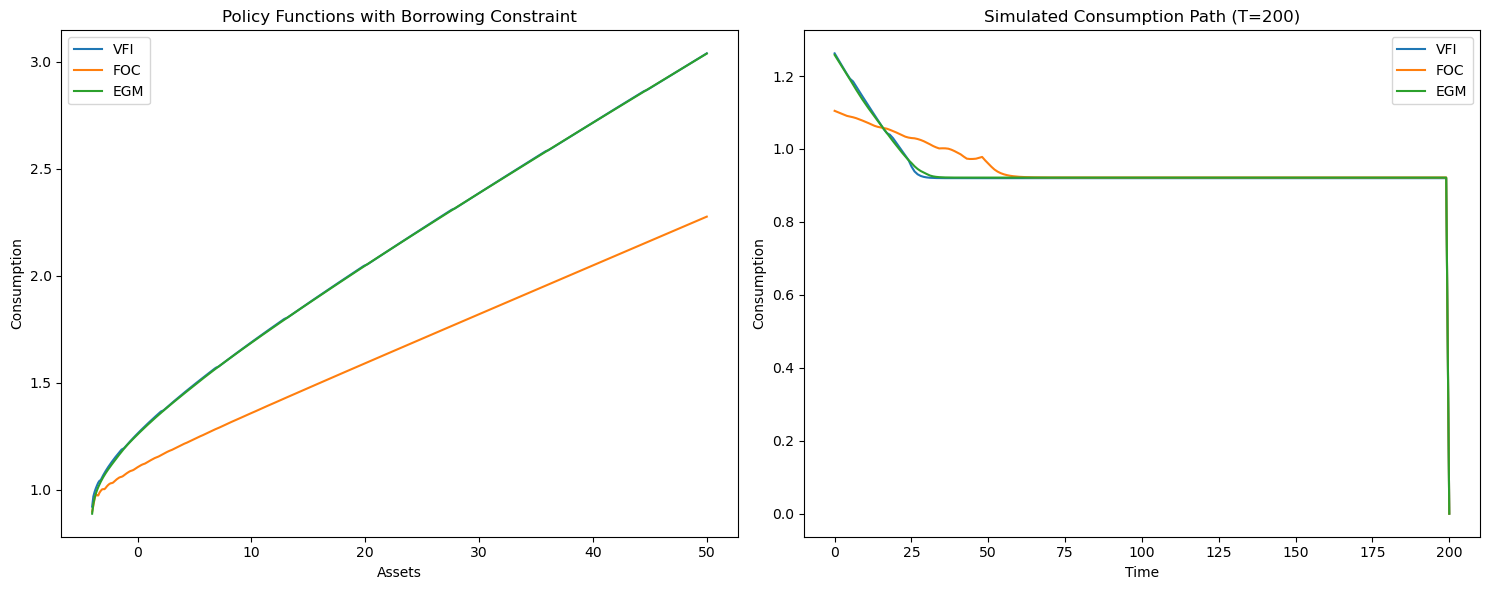

In [61]:
# plot results

plt.figure(figsize=(15, 6))

# policy function plot
plt.subplot(1, 2, 1)
plt.plot(grid_a, policy_vfi, label='VFI')
plt.plot(grid_a, c_foc, label='FOC')
plt.plot(grid_a, c_egm, label='EGM')
plt.title("Policy Functions with Borrowing Constraint")
plt.xlabel("Assets")
plt.ylabel("Consumption")
plt.legend()

# simulated consumption path
plt.subplot(1, 2, 2)
plt.plot(c_vfi, label='VFI')
plt.plot(c_foc_sim, label='FOC')
plt.plot(c_egm_sim, label='EGM')
plt.title("Simulated Consumption Path (T=200)")
plt.xlabel("Time")
plt.ylabel("Consumption")
plt.legend()

plt.tight_layout()
plt.show()